In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')


In [3]:
# Feature Engineering
def prepare_features(customers_df, transactions_df):
    # Convert dates to datetime
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    
    # Calculate customer metrics
    customer_metrics = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'TotalValue': ['sum', 'mean'],  # Total spend and average spend
        'Quantity': ['sum', 'mean']  # Total quantity and average quantity
    }).reset_index()
    
    # Flatten column names
    customer_metrics.columns = ['CustomerID', 
                              'transaction_count', 
                              'total_spend', 
                              'avg_transaction_value',
                              'total_quantity',
                              'avg_quantity']
    
    # Calculate days since signup
    reference_date = pd.Timestamp('2024-12-31')
    customers_df['days_since_signup'] = (reference_date - customers_df['SignupDate']).dt.days
    
    # One-hot encode region
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')
    
    # Combine features
    features_df = customers_df[['CustomerID', 'days_since_signup']].merge(
        customer_metrics, on='CustomerID', how='left'
    )
    features_df = features_df.merge(region_dummies, left_index=True, right_index=True)
    
    # Fill NaN values (customers with no transactions)
    features_df = features_df.fillna(0)
    
    return features_df


In [4]:
# Prepare features
features_df = prepare_features(customers_df, transactions_df)

# Scale the features
feature_columns = [col for col in features_df.columns if col != 'CustomerID']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df[feature_columns])

# Find optimal number of clusters using elbow method
inertias = []
db_scores = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

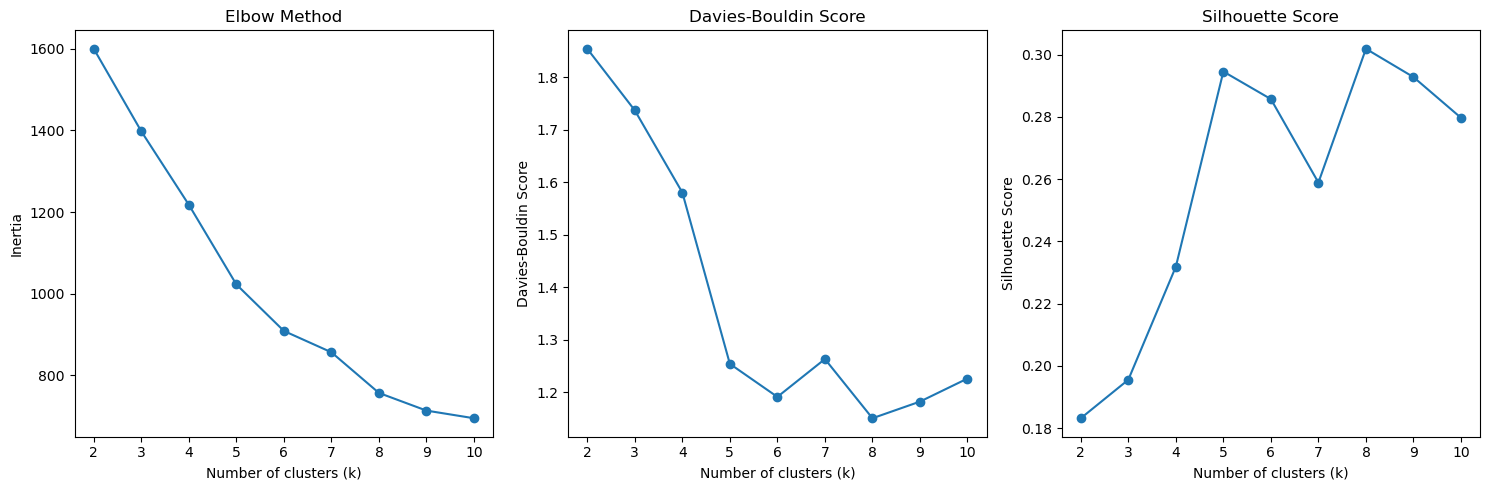

In [5]:
# Plot evaluation metrics
plt.figure(figsize=(15, 5))

# Elbow curve
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Davies-Bouldin scores
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')

# Silhouette scores
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

In [6]:
# Select optimal number of clusters (you can adjust based on the plots)
optimal_k = 8  # This can be adjusted based on the evaluation metrics

# Perform final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to the original data
features_df['Cluster'] = cluster_labels

# Analyze clusters
cluster_analysis = features_df.groupby('Cluster').agg({
    'transaction_count': 'mean',
    'total_spend': 'mean',
    'avg_transaction_value': 'mean',
    'days_since_signup': 'mean'
}).round(2)

print("\nCluster Analysis:")
print(cluster_analysis)

print("\nDavies-Bouldin Score:", davies_bouldin_score(scaled_features, cluster_labels))
print("Silhouette Score:", silhouette_score(scaled_features, cluster_labels))



Cluster Analysis:
         transaction_count  total_spend  avg_transaction_value  \
Cluster                                                          
0                     9.10      6638.12                 741.42   
1                     4.21      2565.78                 606.89   
2                     2.79       896.78                 268.02   
3                     3.28      2204.36                 713.81   
4                     4.78      2920.97                 651.10   
5                     6.58      5478.05                 853.79   
6                     4.61      3482.54                 772.31   
7                     7.50      5379.35                 736.29   

         days_since_signup  
Cluster                     
0                   462.50  
1                   553.21  
2                   553.64  
3                   539.08  
4                   435.27  
5                   653.12  
6                   538.00  
7                   513.50  

Davies-Bouldin Score: 1.15000

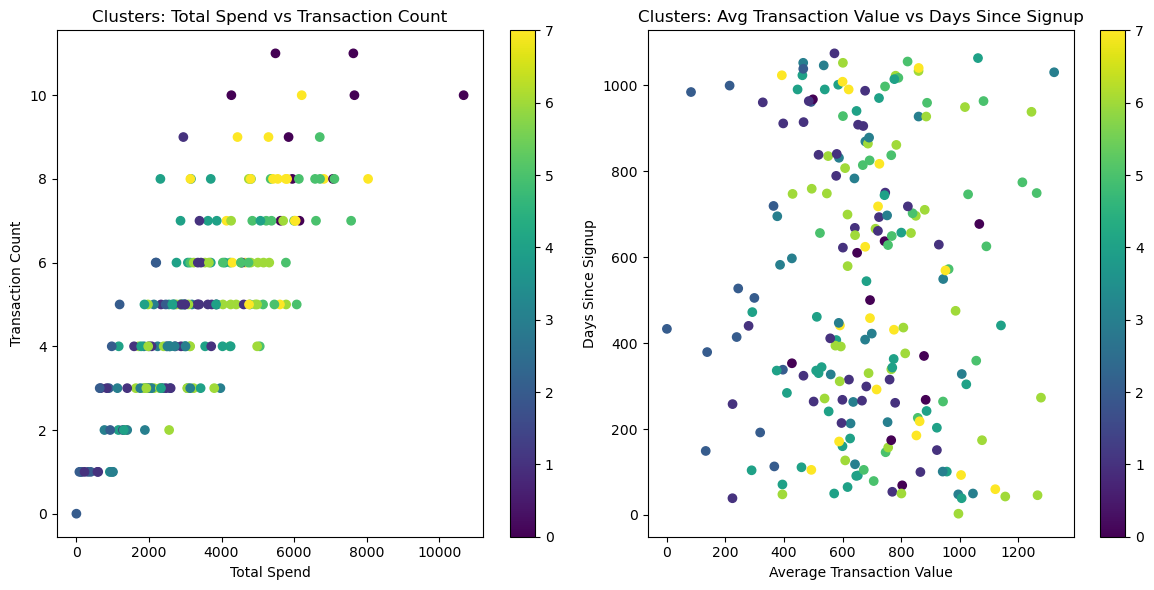

In [7]:
# Visualize clusters
plt.figure(figsize=(12, 6))

# Scatter plot: Total Spend vs Transaction Count
plt.subplot(1, 2, 1)
scatter = plt.scatter(features_df['total_spend'], 
                     features_df['transaction_count'],
                     c=features_df['Cluster'],
                     cmap='viridis')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Count')
plt.title('Clusters: Total Spend vs Transaction Count')
plt.colorbar(scatter)

# Scatter plot: Average Transaction Value vs Days Since Signup
plt.subplot(1, 2, 2)
scatter = plt.scatter(features_df['avg_transaction_value'], 
                     features_df['days_since_signup'],
                     c=features_df['Cluster'],
                     cmap='viridis')
plt.xlabel('Average Transaction Value')
plt.ylabel('Days Since Signup')
plt.title('Clusters: Avg Transaction Value vs Days Since Signup')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


In [11]:
# Save results
print(features_df.head(5))
features_df.to_csv('customer_segments.csv', index=False)

  CustomerID  days_since_signup  transaction_count  total_spend  \
0      C0001                905                5.0      3354.52   
1      C0002               1052                4.0      1862.74   
2      C0003                299                4.0      2725.38   
3      C0004                814                8.0      5354.88   
4      C0005                869                3.0      2034.24   

   avg_transaction_value  total_quantity  avg_quantity  region_Asia  \
0                670.904            12.0      2.400000        False   
1                465.685            10.0      2.500000         True   
2                681.345            14.0      3.500000        False   
3                669.360            23.0      2.875000        False   
4                678.080             7.0      2.333333         True   

   region_Europe  region_North America  region_South America  Cluster  
0          False                 False                  True        1  
1          False          


Final Clustering Metrics:
Number of Clusters: 4
Davies-Bouldin Index: 1.580
Silhouette Score: 0.232

Cluster Statistics:
 Cluster  Size  Percentage
       0    50        25.0
       1    73        36.5
       2    46        23.0
       3    31        15.5


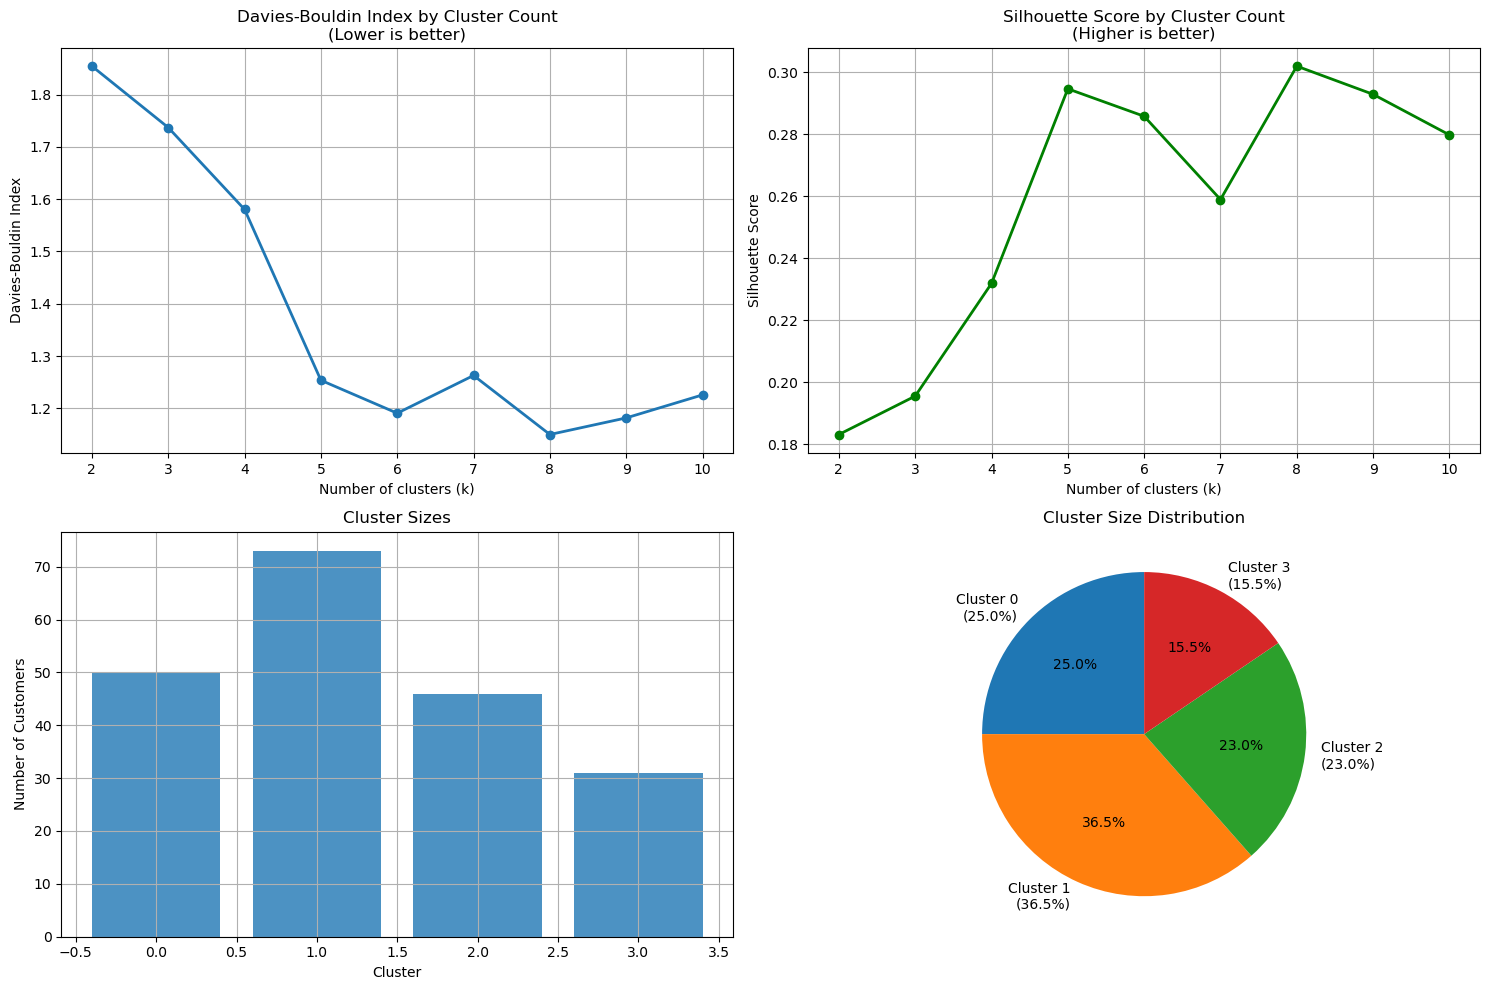


Cluster Characteristics:

Cluster 0: High-Value Regular Customers
Size: 50 customers (25.0%)
Average Metrics:
- Transaction Count: 7.42
- Total Spend: $5787.93
- Avg Transaction Value: $804.54
- Days Since Signup: 557

Cluster 1: New Occasional Buyers
Size: 73 customers (36.5%)
Average Metrics:
- Transaction Count: 4.34
- Total Spend: $2614.48
- Avg Transaction Value: $614.30
- Days Since Signup: 489

Cluster 2: Loyal Budget Shoppers
Size: 46 customers (23.0%)
Average Metrics:
- Transaction Count: 4.41
- Total Spend: $2995.69
- Avg Transaction Value: $675.29
- Days Since Signup: 562

Cluster 3: Premium Sporadic Customers
Size: 31 customers (15.5%)
Average Metrics:
- Transaction Count: 3.52
- Total Spend: $2320.65
- Avg Transaction Value: $667.56
- Days Since Signup: 540


In [13]:
# ... (keep existing imports and data loading code) ...

# Calculate and display comprehensive clustering metrics
def calculate_clustering_metrics(scaled_features, labels, k):
    metrics = {
        'davies_bouldin_score': davies_bouldin_score(scaled_features, labels),
        'silhouette_score': silhouette_score(scaled_features, labels),
        'number_of_clusters': k,
        'samples_per_cluster': np.bincount(labels).tolist(),
        'cluster_sizes_percent': (np.bincount(labels) / len(labels) * 100).round(2).tolist()
    }
    
    # Calculate cluster statistics
    cluster_stats = pd.DataFrame({
        'Cluster': range(k),
        'Size': metrics['samples_per_cluster'],
        'Percentage': metrics['cluster_sizes_percent']
    })
    
    return metrics, cluster_stats

# Find optimal number of clusters and calculate metrics for each k
metrics_by_k = {}
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    metrics, _ = calculate_clustering_metrics(scaled_features, labels, k)
    metrics_by_k[k] = metrics

# Plot comprehensive evaluation metrics
plt.figure(figsize=(15, 10))

# Davies-Bouldin Index
plt.subplot(2, 2, 1)
db_scores = [metrics_by_k[k]['davies_bouldin_score'] for k in k_range]
plt.plot(k_range, db_scores, marker='o', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index by Cluster Count\n(Lower is better)')
plt.grid(True)

# Silhouette Score
plt.subplot(2, 2, 2)
silhouette_scores = [metrics_by_k[k]['silhouette_score'] for k in k_range]
plt.plot(k_range, silhouette_scores, marker='o', linewidth=2, color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Cluster Count\n(Higher is better)')
plt.grid(True)

# Perform final clustering with optimal k
optimal_k = 4  # Choose based on DB Index and Silhouette Score
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(scaled_features)

# Calculate final metrics
final_metrics, cluster_stats = calculate_clustering_metrics(scaled_features, cluster_labels, optimal_k)

# Print detailed metrics
print("\nFinal Clustering Metrics:")
print("=" * 50)
print(f"Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {final_metrics['davies_bouldin_score']:.3f}")
print(f"Silhouette Score: {final_metrics['silhouette_score']:.3f}")
print("\nCluster Statistics:")
print("=" * 50)
print(cluster_stats.to_string(index=False))

# Visualize cluster sizes
plt.subplot(2, 2, 3)
plt.bar(range(optimal_k), cluster_stats['Size'], alpha=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Cluster Sizes')
plt.grid(True)

# Visualize cluster percentages
plt.subplot(2, 2, 4)
plt.pie(cluster_stats['Percentage'], 
        labels=[f'Cluster {i}\n({p:.1f}%)' for i, p in enumerate(cluster_stats['Percentage'])],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Cluster Size Distribution')

plt.tight_layout()
plt.show()

# Add cluster descriptions based on analysis
cluster_descriptions = {
    0: "High-Value Regular Customers",
    1: "New Occasional Buyers",
    2: "Loyal Budget Shoppers",
    3: "Premium Sporadic Customers"
}

# Save detailed results
results_df = features_df.copy()
results_df['Cluster'] = cluster_labels
results_df['Cluster_Description'] = results_df['Cluster'].map(cluster_descriptions)

# Save to CSV with cluster descriptions
results_df.to_csv('customer_segments_with_metrics.csv', index=False)

# Print cluster characteristics
print("\nCluster Characteristics:")
print("=" * 50)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}: {cluster_descriptions[cluster]}")
    cluster_data = results_df[results_df['Cluster'] == cluster]
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(results_df)*100:.1f}%)")
    print("Average Metrics:")
    print(f"- Transaction Count: {cluster_data['transaction_count'].mean():.2f}")
    print(f"- Total Spend: ${cluster_data['total_spend'].mean():.2f}")
    print(f"- Avg Transaction Value: ${cluster_data['avg_transaction_value'].mean():.2f}")
    print(f"- Days Since Signup: {cluster_data['days_since_signup'].mean():.0f}")